# <font color=darkolivegreen> Определение неэффективных операторов в сервисе "Нупозвони"</font> 

## <font color=olive>Описание данных</font>

#### <font color=olivedrab>Таблица telecom_dataset.csv.zip:</font>

 - user_id — идентификатор клиентского аккаунта в сервисе;
 - date — дата статистики;
 - direction — направление вызовов (out - исходящий вызов, in — входящий вызов);
 - internal — является ли звонок внутренним звонком между операторами клиента;
 - operator_id — идентификатор оператора;
 - is_missed_call — является ли звонок пропущенным;
 - calls_count — количество звонков;
 - call_duration — длительность звонка (без учета времени ожидания);
 - total_call_duration — длительность звонка (с учетом времени ожидания).

#### <font color=olivedrab>Таблица telecom_clients.csv:</font>

 - user_id — идентификатор клиентского аккаунта в сервисе
 - tariff_plan —  текущий тарифный план клиента
 - date_start — дата регистрации клиента в сервисе

#### <font color=olivedrab>Оглавление </font>

1. [Открытие данных](#открытие)
2. [Предобработка данных](#предобработка)
    * [Предобработка таблицы telecom_dataset](#telecom_dataset)
    * [Предобработка таблицы telecom_clients](#telecom_clients)
    * [Вывод](#вывод_предобработка)  
3. [Исследовательский анализ данных](#eda)
    * [Аномалии столбца calls_count](#calls_count)
    * [Аномалии столбца avg_call_duration](#avg_call_duration)
    * [Аномалии столбца avg_expectation_duration](#avg_expectation_duration)
    * [Вывод](#вывод_eda)
4. [Определение неэффективных операторов и клиентов с неэффективными операторами](#определение)
    * [Определение неэффективных операторов по признаку длительности времени ожидания ответа на звонок](#долгое_ожидание)
    * [Определение неэффективных операторов по признаку количества пропущенных звонков](#много_пропущенных)
    * [Определение неэффективных операторов по 2 признакам](#неэффективные)
    * [Определение клиентов с неэффективными операторами](#клиенты_с_неэффективными)
    * [Вывод](#вывод_определение)
5. [Проверка гипотез](#гипотезы)
6. [Общий вывод](#вывод)
7. [Презентация](#презентация)
8. [Дашборды](#дашборд)


### <font color=olive>Открытие данных и изучение общей информации</font> <a id="открытие"></a>

In [121]:
# импортируем данные
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math as mth
from datetime import datetime, time
from matplotlib import pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st
from scipy.stats.mstats import mode

In [122]:
#сохраним исходные таблицы в переменные:
telecom_dataset = pd.read_csv('telecom_dataset.csv')
telecom_clients = pd.read_csv('telecom_clients.csv')

In [123]:
telecom_dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [124]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


В таблице telecom_dataset представлены данные о звонках, сгруппированных по признакам:
 - user_id — идентификатор клиентского аккаунта в сервисе;
 - date — дата статистики;
 - direction — направление вызовов (out - исходящий вызов, in — входящий вызов);
 - internal — является ли звонок внутренним звонком между операторами клиента;
 - operator_id — идентификатор оператора;
 - is_missed_call — является ли звонок пропущенным;
 - calls_count — количество звонков;
 - call_duration — длительность звонка (без учета времени ожидания);
 - total_call_duration — длительность звонка (с учетом времени ожидания).

Всего содержится 53 902 записи. В графе с информацией о том, является ли звонок внутренним или внешним есть пропущенные значения. Так же не во всех строках проставлен id оператора. Тип данных столбца date необходимо в дальнейшем заменить на дату.

In [125]:
telecom_clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [126]:
telecom_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


В таблице telecom_clients содержится информация о 732 клиентах сервиса с указанием тарифного плана клиента и даты его регистрации. Пропусков нет, тип данных столбца date_start в дальнейшем необходимо заменим на дату.

### <font color=olive>Предобработка данных</font>  <a id="предобработка"></a>

##### Таблица telecom_dataset <a id="telecom_dataset"></a>

Заполним пропущенные значения в столбце operator_id самым часто встречающимся значением айди оператора по каждому клиенту:

In [127]:
mode =  telecom_dataset['operator_id'].mode()[0]
telecom_dataset['operator_id'] = telecom_dataset.groupby('user_id')['operator_id'].apply(lambda x: x.fillna(x.value_counts().idxmax() if x.value_counts().max() >=1 else mode , inplace = False))
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            53902 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Удалим строки с отсутствующими данными по графе internal:

In [130]:
telecom_dataset.dropna(inplace=True)
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53785 non-null int64
date                   53785 non-null object
direction              53785 non-null object
internal               53785 non-null object
operator_id            53785 non-null float64
is_missed_call         53785 non-null bool
calls_count            53785 non-null int64
call_duration          53785 non-null int64
total_call_duration    53785 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.7+ MB


Теперь проверим таблицу telecom_dataset на наличие дубликатов: 

In [131]:
telecom_dataset.duplicated().sum()

4895

Около 9% содержащихся в таблице строк - полные дубликаты уже имеющихся. Удалим их:

In [132]:
telecom_dataset = telecom_dataset.drop_duplicates().reset_index().drop('index', axis = 1)
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48890 entries, 0 to 48889
Data columns (total 9 columns):
user_id                48890 non-null int64
date                   48890 non-null object
direction              48890 non-null object
internal               48890 non-null object
operator_id            48890 non-null float64
is_missed_call         48890 non-null bool
calls_count            48890 non-null int64
call_duration          48890 non-null int64
total_call_duration    48890 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.0+ MB


Заменим тип данных столбца date на дату, а тип данных столбца operator_id на int64:

In [133]:
#telecom_dataset['date'] = pd.to_datetime(telecom_dataset['date'], format='%Y-%m-%dT%H:%M:%S')
telecom_dataset['date'] = pd.to_datetime(telecom_dataset['date'])
telecom_dataset['date'] = telecom_dataset['date'].dt.date
telecom_dataset['operator_id'] = telecom_dataset['operator_id'].astype('int64')

Добавим столбец с длительностью ожидания ответа на звонок и столбцы с расчетным временем длительности 1 звонка без учета времени ожидания, с учетом времени ожидания и длительности ожидания на 1 звонок:

In [134]:
telecom_dataset['expectation_duration'] = telecom_dataset['total_call_duration'] - telecom_dataset['call_duration']
telecom_dataset['avg_call_duration'] = (telecom_dataset['call_duration'] / telecom_dataset['calls_count']).round(2)
telecom_dataset['avg_total_call_duration'] = (telecom_dataset['total_call_duration'] / telecom_dataset['calls_count']).round(2)
telecom_dataset['avg_expectation_duration'] = (telecom_dataset['expectation_duration'] / telecom_dataset['calls_count']).round(2)

##### Таблица telecom_clients <a id="telecom_clients"></a>

Проверим наличие дубликатов в таблице:

In [135]:
telecom_clients.duplicated().sum()

0

Дубликатов нет.

Заменим тип данных столбца date_start на дату:

In [136]:
telecom_clients['date_start'] = pd.to_datetime(telecom_clients['date_start'], format='%Y-%m-%d')

И объединим таблицы по графе user_id для удобства дальнейшего анализа:

In [137]:
telecom_dataset = telecom_dataset.merge(telecom_clients, on = 'user_id')

In [138]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48890 entries, 0 to 48889
Data columns (total 15 columns):
user_id                     48890 non-null int64
date                        48890 non-null object
direction                   48890 non-null object
internal                    48890 non-null object
operator_id                 48890 non-null int64
is_missed_call              48890 non-null bool
calls_count                 48890 non-null int64
call_duration               48890 non-null int64
total_call_duration         48890 non-null int64
expectation_duration        48890 non-null int64
avg_call_duration           48890 non-null float64
avg_total_call_duration     48890 non-null float64
avg_expectation_duration    48890 non-null float64
tariff_plan                 48890 non-null object
date_start                  48890 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(3), int64(6), object(4)
memory usage: 5.6+ MB


### Вывод </font> <a id="вывод_предобработка"></a>

В ходе предобработки были
- заменены типы данных столбцов, содержащих дату, на корректный;
- заполнены пропущенные значения столбца operator_id;
- удалены строки (всего 117) с пропущенными значениями столбца internal;
- удалены дублирующие строки (4 895);
- добавлены столбцы с длительностью ожидания ответа на звонок, со средней длительностью 1 звонка без и с учетом времени ожидания и время ожидания ответа на 1 звонок.

Так же на этом этапе таблицы были объединены по графе user_id. Для дальнейшего анализа осталось 48 890 строк.

### <font color=olive>Исследовательский анализ данных</font> <a id="eda"></a>

##### Проверим столбец calls_count: <a id="calls_count"></a>

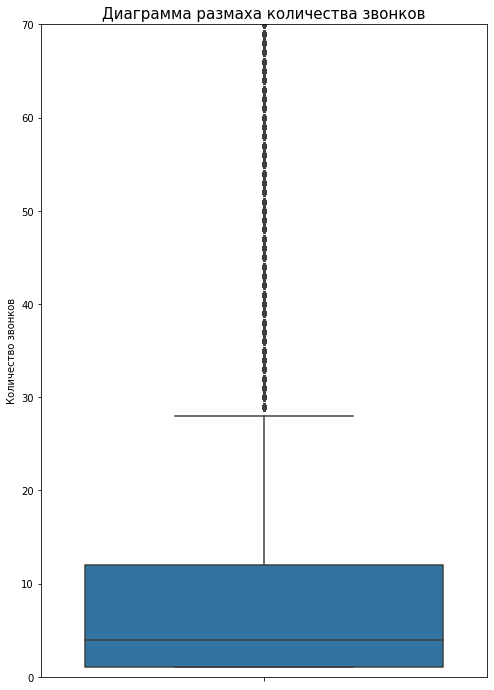

In [139]:
plt.figure(figsize=(8, 12))
plt.ylim(0, 70)
sns.boxplot(y="calls_count", data = telecom_dataset)
plt.title("Диаграмма размаха количества звонков", size=15)
plt.ylabel("Количество звонков")
plt.show()

In [140]:
telecom_dataset['calls_count'].describe()

count    48890.000000
mean        16.495848
std         63.672858
min          1.000000
25%          1.000000
50%          4.000000
75%         12.000000
max       4817.000000
Name: calls_count, dtype: float64

В среднем, количество звонков в каждой строке находится в диапазоне от 1 до 12. Отбросим строки, количество звонков в которых находятся за границами диаграммы размаха:

In [141]:
telecom_dataset = telecom_dataset.query('calls_count < 28.5')

##### Рассмотрим столбец avg_call_duration: <a id="avg_call_duration"></a>

In [142]:
telecom_dataset.query('avg_call_duration != 0')['is_missed_call'].value_counts()

False    24059
True       295
Name: is_missed_call, dtype: int64

In [143]:
telecom_dataset.query('avg_call_duration == 0')['is_missed_call'].value_counts()

True     18473
False       17
Name: is_missed_call, dtype: int64

В таблице содержится 295 записей, в которых ненулевая длительность звонков, но запись обозначена как пропущенная, а также 17 строк, в которых длительность звонков нулевая, но отмечено, что звонок не пропущен. Не будем учитывать эти строки в дальнейшем анализе:

In [144]:
telecom_dataset = (telecom_dataset[(~(telecom_dataset['avg_call_duration'] == 0) & (telecom_dataset['is_missed_call'] == False)) |
                  ((telecom_dataset['avg_call_duration'] == 0) & (telecom_dataset['is_missed_call'] == True))])

##### Рассмотрим столбец avg_expectation_duration: <a id="avg_expectation_duration"></a>

Проверим распределение значений средней длительности ожидания звонка. Причем в целях оценки эффективности операторов, лучше рассматривать именно входящие звонки:

In [145]:
telecom_dataset.query('direction == "in"')['avg_expectation_duration'].describe()

count    18465.000000
mean        17.566961
std         17.277378
min          0.000000
25%          7.000000
50%         13.500000
75%         24.000000
max        465.000000
Name: avg_expectation_duration, dtype: float64

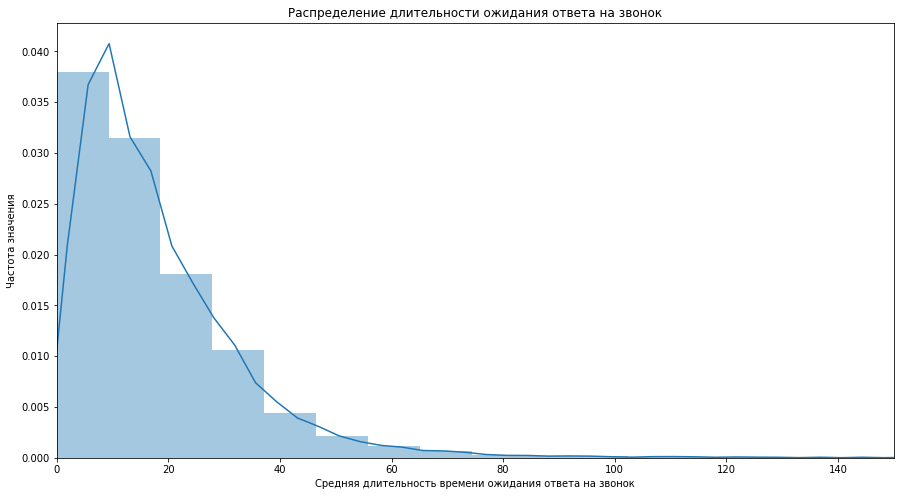

In [146]:
plt.figure(figsize=(15, 8))
sns.distplot(telecom_dataset.query('direction == "in"')['avg_expectation_duration'])
plt.xlim(0, 150)
plt.title('Распределение длительности ожидания ответа на звонок', size=12)
plt.xlabel("Средняя длительность времени ожидания ответа на звонок")
plt.ylabel("Частота значения")
plt.show()

Основная масса звонков с длительностью ожидания около 10 секунд. Как видно из графика, много звонков с длительностью ожидания 0-1 секунды, возможно этого времени оператору не хватило бы даже ответить, звонок по какой-то причине сорвался, но уже попал в категорию пропущенных. Исключим из дальнейшего анализа звонки, длительность ожидания ответа на которые менее 3 секунд: 

In [147]:
telecom_dataset = telecom_dataset[~((telecom_dataset['direction'] == "in") & (telecom_dataset['avg_expectation_duration'] < 3))]

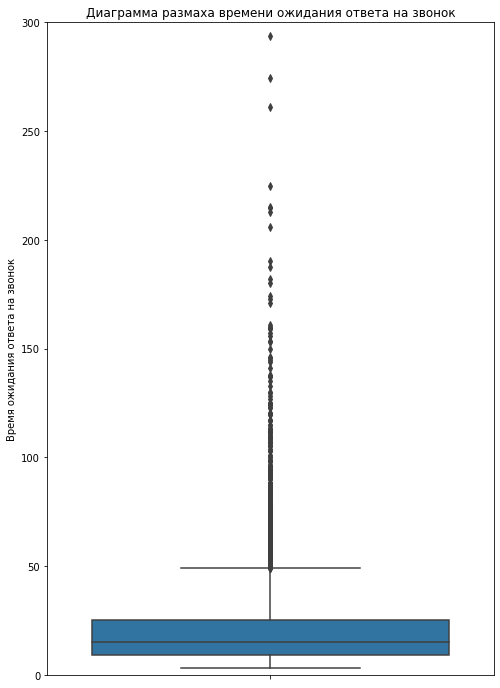

In [148]:
plt.figure(figsize=(8, 12))
plt.ylim(0, 300)
sns.boxplot(y="avg_expectation_duration", data = telecom_dataset.query('direction == "in"'))
plt.title("Диаграмма размаха времени ожидания ответа на звонок")
plt.ylabel("Время ожидания ответа на звонок")
plt.show()

In [149]:
telecom_dataset.query('direction == "in"')['avg_expectation_duration'].describe()

count    16505.000000
mean        19.490563
std         17.292256
min          3.000000
25%          9.000000
50%         15.120000
75%         25.000000
max        465.000000
Name: avg_expectation_duration, dtype: float64

В среднем, время ожидания ответа на входящий звонок находится в  диапазоне от 9 до 25. Исключим из дальнейшего анализа звонки, длительность ожидания которых находится за границами диаграммы размаха:

In [150]:
telecom_dataset = telecom_dataset[~((telecom_dataset['direction'] == "in") & (telecom_dataset['avg_expectation_duration'] > 50))]

### Вывод </font> <a id="вывод_eda"></a>

В ходе исследовательского анализа были выявлены и исключены из дальнейшего анализа аномалии в столбцах содержащих данные о количестве пропущенных звонков и о длительности ожидания ответа на звонок.

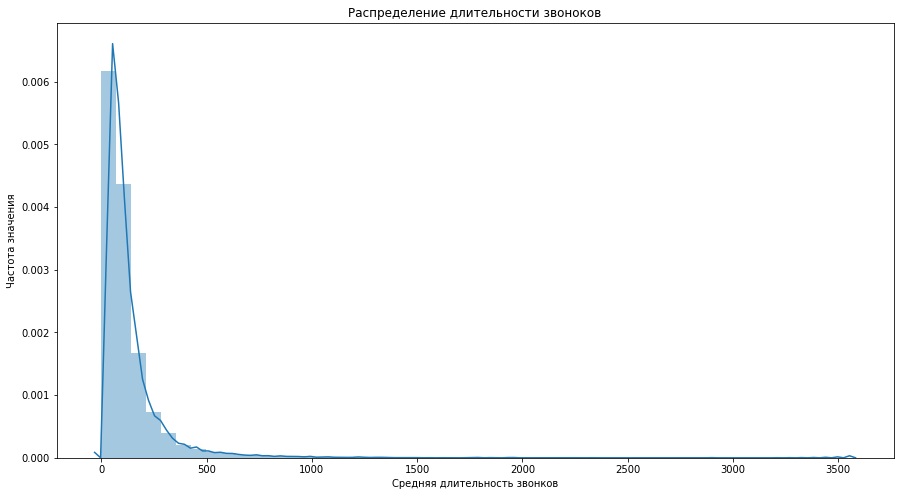

In [151]:
plt.figure(figsize=(15, 8))
sns.distplot(telecom_dataset.query('is_missed_call == False')['avg_call_duration'])
plt.title('Распределение длительности звоноков', size=12)
plt.xlabel("Средняя длительность звонков")
plt.ylabel("Частота значения")
plt.show()

Основная масса звонков длительностью около 100 секунд. Как видно из графика, много звонков с длительностью в районе 0 секунд,  Исключим из дальнейшего анализа звонки, которыех менее 10 секунд:

In [152]:
telecom_dataset = telecom_dataset[~((telecom_dataset['is_missed_call'] == False) & (telecom_dataset['avg_call_duration'] < 10))]

In [153]:
telecom_dataset.query('is_missed_call == False')['avg_call_duration'].describe()

count    22443.000000
mean       128.367734
std        158.387330
min         10.000000
25%         47.110000
50%         85.220000
75%        148.330000
max       3550.000000
Name: avg_call_duration, dtype: float64

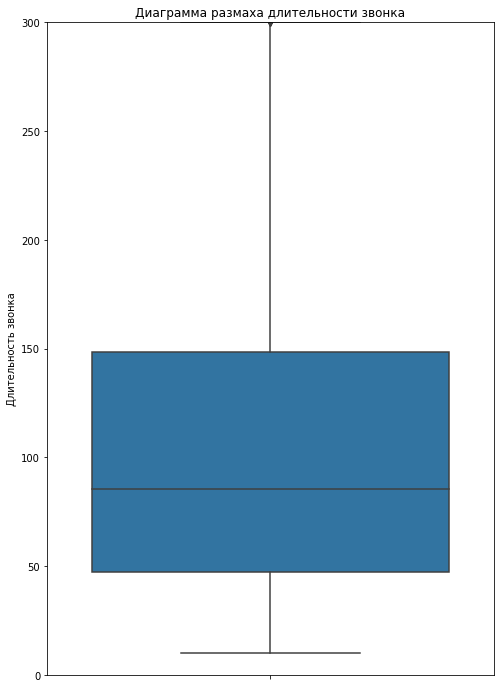

In [154]:
plt.figure(figsize=(8, 12))
plt.ylim(0, 300)
sns.boxplot(y="avg_call_duration", data = telecom_dataset.query('is_missed_call == False'))
plt.title("Диаграмма размаха длительности звонка")
plt.ylabel("Длительность звонка")
plt.show()

В среднем, длительность звонка находится в диапазоне от 47 до 148. Исключим из дальнейшего анализа звонки, длительность которых находится за границами диаграммы размаха:

In [155]:
telecom_dataset = telecom_dataset[~((telecom_dataset['direction'] == "in") & (telecom_dataset['avg_call_duration'] > 300))]

In [156]:
telecom_dataset.to_csv('telecom_dataset_dash.csv', sep=',')

### <font color=olive>Определение неэффективных операторов и клиентов с неэффективными операторами</font> <a id="определение"></a>

Рассмотрим диаграмму размаха времени ожидания ответа на звонок: <a id="долгое_ожидание"></a>

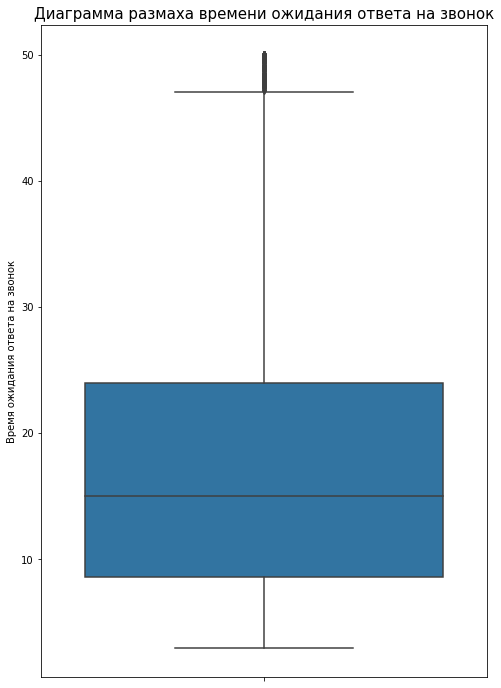

In [157]:
plt.figure(figsize=(8, 12))
sns.boxplot(y="avg_expectation_duration", data = telecom_dataset.query('direction == "in"'))
plt.title("Диаграмма размаха времени ожидания ответа на звонок", size=15)
plt.ylabel("Время ожидания ответа на звонок")
plt.show()

In [158]:
telecom_dataset.query('direction == "in"')['avg_expectation_duration'].describe()

count    14767.000000
mean        17.300245
std         10.728456
min          3.000000
25%          8.600000
50%         15.000000
75%         24.000000
max         50.000000
Name: avg_expectation_duration, dtype: float64

Как видно из графика, длительность ожидания входящих 75% звонков составляет примерно 25 секунд. Будем считать, что звонок, длительность времени ожидания ответа на который превышает 25 секунд, является поводом для отнесения оператора к неэффективным.

In [159]:
long_expectation = telecom_dataset.query('direction == "in" and avg_expectation_duration > 25')

telecom_dataset_by_operator_id = telecom_dataset.groupby('operator_id')['calls_count'].sum().reset_index()

# сгруппируем полученную таблицу по операторам и по каждому оператору посчитаем количество звонков с длительностью ожидания
# более 25 секунд:
long_expectation_by_operator_id = (long_expectation.groupby(['user_id', 'operator_id'])['calls_count'].sum().reset_index())

# объединим полученную сгруппированную таблицу с исходной таблицей, также сгруппированную по операторам:
long_expectation_by_operator_id = (long_expectation_by_operator_id.merge(telecom_dataset_by_operator_id, on = 'operator_id')
                                                                  .rename(columns={'calls_count_x':'calls_long_expectation',
                                                                                   'calls_count_y':'total_calls'}))

# посчитаем долю звонков с долгим временем ожидания в общем количестве звонков по каждому оператору:
long_expectation_by_operator_id['expectation_share'] = ((long_expectation_by_operator_id['calls_long_expectation'] * 100 
                                                         / long_expectation_by_operator_id['total_calls']).round(2))

Рассмотрим диаграмму размаха доли звонков с долгим временем ожидания в общем количестве звонков по операторам:

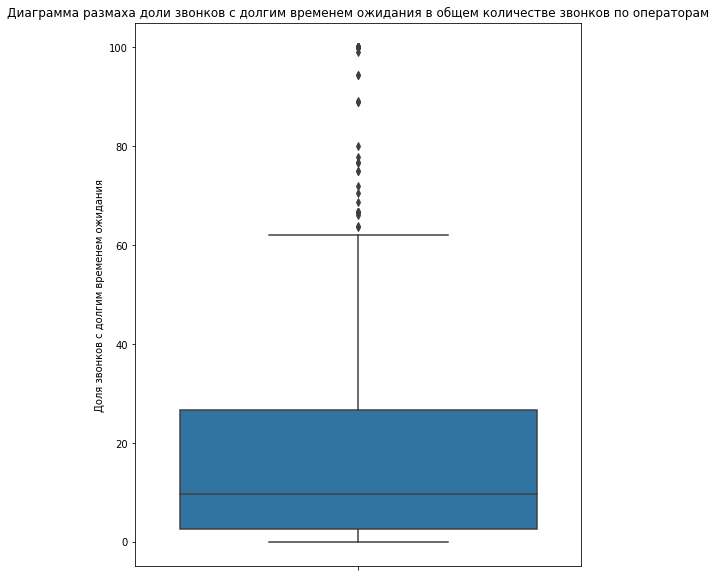

In [160]:
plt.figure(figsize=(8, 10))
sns.boxplot(y="expectation_share", data = long_expectation_by_operator_id)
plt.title("Диаграмма размаха доли звонков с долгим временем ожидания в общем количестве звонков по операторам")
plt.ylabel("Доля звонков с долгим временем ожидания")
plt.show()

In [161]:
long_expectation_by_operator_id['expectation_share'].describe()

count    433.000000
mean      20.746697
std       26.462321
min        0.050000
25%        2.500000
50%        9.750000
75%       26.670000
max      100.000000
Name: expectation_share, dtype: float64

Типичный оператор имеет долю звонков с долгим временем ожидания ответа на входящий звонок от 2.5% до 27,5%. Тогда, будем считать, что если у оператора более 27,5% звонков с длительностью ожидания ответа более 25 секунд в общем количестве звонков, то такой оператор - неэффективный

In [162]:
ineffective_by_expectation = (long_expectation_by_operator_id.query('expectation_share > 27.5')
                                                            .sort_values(by = 'expectation_share', ascending = False))
ineffective_by_expectation

,user_id,operator_id,calls_long_expectation,total_calls,expectation_share
198,167176,905478,1,1,100.00
370,168121,940508,2,2,100.00
329,167976,934432,4,4,100.00
138,166975,899898,1,1,100.00
77,166732,909624,3,3,100.00
...,...,...,...,...,...
168,167071,913938,319,1053,30.29
342,168008,948524,3,10,30.00
394,168193,947816,19,66,28.79
112,166908,895786,14,49,28.57


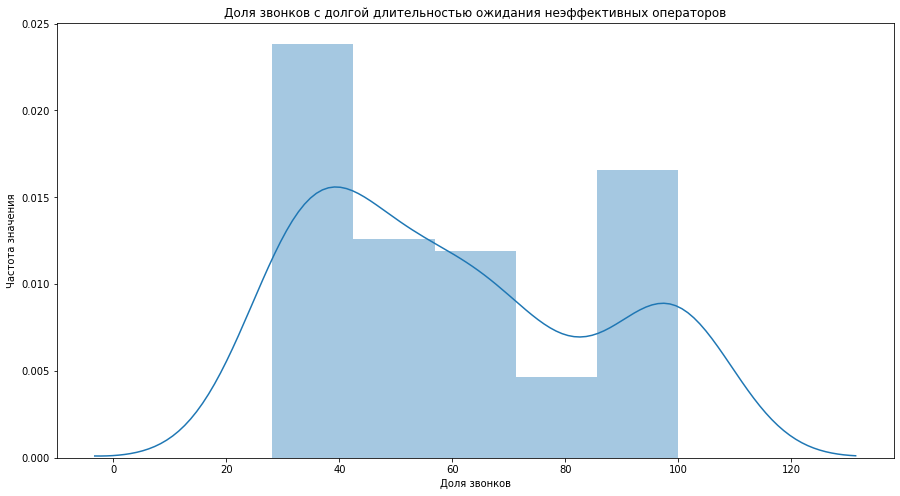

In [163]:
plt.figure(figsize=(15, 8))
sns.distplot(ineffective_by_expectation['expectation_share'])
plt.title('Доля звонков с долгой длительностью ожидания неэффективных операторов', size=12)
plt.xlabel("Доля звонков")
plt.ylabel("Частота значения")
plt.show()

В итоговую таблицу неэффективных операторов по длительности ожидания ответа на звонок попало 105 операторов с процентом звонков с долгим ожиданием ответа от 27,5 до 100. Основная масса таких операторов имеет небольшой процент звонков с длительным ожиданием - 27,5-70%%. Достаточно много операторов с долей звонков с долгим ожиданием от 90% до 100% - скорее всего это новые неопытные операторы.

Рассмотрим строки с пропущенными входящими звонками: <a id="много_пропущенных"></a>

In [164]:
is_missed_incoming = telecom_dataset[(telecom_dataset['direction'] == "in") & (telecom_dataset['is_missed_call'] == True)]

# сгруппируем полученную таблицу по операторам и посчитаем по каждому количество пропущенных звонков:
is_missed_incoming_by_operator_id = (is_missed_incoming.groupby('operator_id')['calls_count'].sum().reset_index())

# объединим полученную сгруппированную таблицу с исходной таблицей, также сгруппированную по операторам:
is_missed_incoming_by_operator_id = (is_missed_incoming_by_operator_id.merge(telecom_dataset_by_operator_id, on = 'operator_id')
                                                                      .rename(columns={'calls_count_x':'count_missing_calls',
                                                                                       'calls_count_y':'total_calls'}))

# посчитаем долю пропущенных звонков в лбщем количестве звонков по каждому оператору:
is_missed_incoming_by_operator_id['share_missing_calls'] = ((is_missed_incoming_by_operator_id['count_missing_calls'] * 100 
                                                             / is_missed_incoming_by_operator_id['total_calls']).round(2))

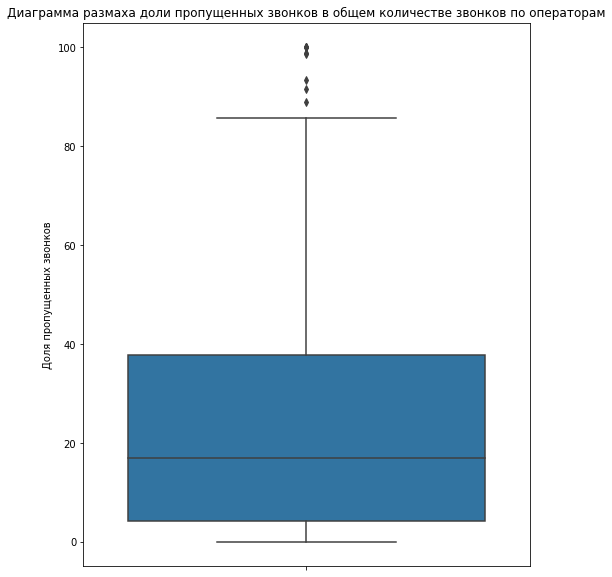

In [165]:
plt.figure(figsize=(8, 10))
sns.boxplot(y="share_missing_calls", data = is_missed_incoming_by_operator_id)
plt.title("Диаграмма размаха доли пропущенных звонков в общем количестве звонков по операторам")
plt.ylabel("Доля пропущенных звонков")
plt.show()

In [166]:
is_missed_incoming_by_operator_id['share_missing_calls'].describe()

count    352.000000
mean      24.487585
std       24.268497
min        0.050000
25%        4.275000
50%       16.980000
75%       37.700000
max      100.000000
Name: share_missing_calls, dtype: float64

В среднем доля входящих пропущенных звонков у операторов находится в диапазоне от 4% до 38%. Будем считать, что при превышении этого порога - 38%, оператора можно признать неэффективным по признаку большого количества пропущенных звонков.

In [167]:
ineffective_by_missing = (is_missed_incoming_by_operator_id.query('share_missing_calls > 38')
                                                          .sort_values(by = 'share_missing_calls', ascending = False))
ineffective_by_missing

,operator_id,count_missing_calls,total_calls,share_missing_calls
344,964518,4,4,100.00
298,944908,4,4,100.00
322,952734,1,1,100.00
326,952982,16,16,100.00
321,952678,95,96,98.96
...,...,...,...,...
201,927142,2,5,40.00
169,919792,486,1233,39.42
264,938432,5,13,38.46
74,900614,35,91,38.46


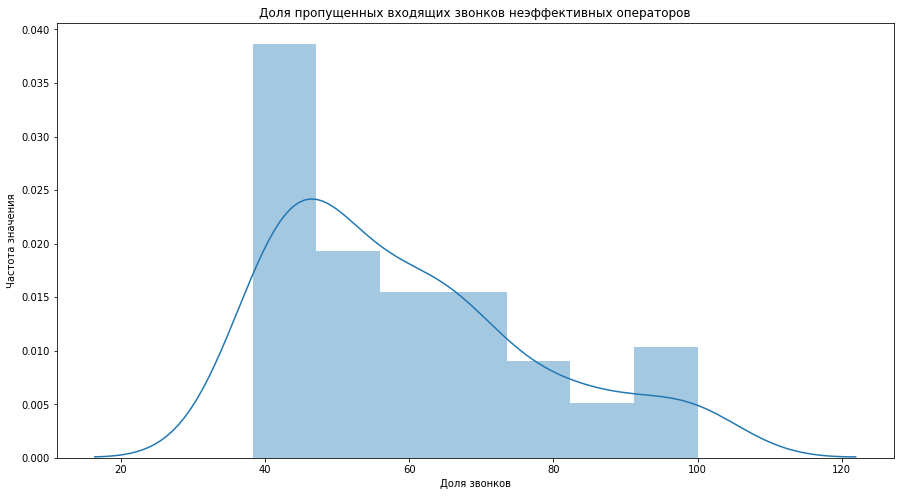

In [168]:
plt.figure(figsize=(15, 8))
sns.distplot(ineffective_by_missing['share_missing_calls'])
plt.title('Доля пропущенных входящих звонков неэффективных операторов', size=12)
plt.xlabel("Доля звонков")
plt.ylabel("Частота значения")
plt.show()

В итоговую таблицу неэффективных операторов по количеству пропущенных входящих звонков попало 88 операторов с долей пропущенных звонков от 38% до 100%. Основная масса таких операторов с долей пропущенных звонков 38% - 70%.

Рассмотрим операторов, которые одновременно попали и в таблицу с долгим ожиданием ответа на звонок и в таблицу с большим количество пропущенных звонков. Для этого объединим таблицы:
<a id="неэффективные"></a>

In [169]:
ineffective = (ineffective_by_expectation.merge(ineffective_by_missing, on = 'operator_id'))[['operator_id', 'expectation_share', 'share_missing_calls']]

ineffective

,operator_id,expectation_share,share_missing_calls
0,970254,76.67,66.67
1,919792,66.18,39.42
2,901350,61.51,66.91
3,891906,55.32,42.55
4,934430,52.63,44.74
5,962062,51.52,54.55
6,950640,50.00,50.00
7,953952,42.86,50.00
8,882478,42.86,85.71
9,918888,40.74,66.67


В итоговую таблицу с неэффективными операторами по двум признакам попали 22 оператора. Нужно рассмотреть каких клиентов обслуживают эти операторы. Запишем их id в переменную:
<a id="клиенты_с_неэффективными"></a>

In [170]:
ineffective_operators_id = ineffective['operator_id']

# и выберем клиентов, которых обслуживают неэффективные операторы:
user_id_ineff_op = (telecom_dataset.query('operator_id in @ineffective_operators_id')
                                   .pivot_table(index = ['user_id', 'operator_id'], values = 'calls_count', aggfunc = 'sum')
                                   .reset_index().sort_values(by = 'calls_count', ascending = False))
         
# объединим полученную таблицу с таблицей telecom_dataset, сгруппированной по клиентам и с подсчитанной суммой всех звонков:
finish_user_id = (user_id_ineff_op.merge(telecom_dataset.groupby('user_id')['calls_count'].sum().reset_index(), on = 'user_id')
                                  .rename(columns={'calls_count_x':'inefcalls_count',
                                                  'calls_count_y':'total_calls'}))
# доля звонков, обслуженных неэффективными операторами:
finish_user_id['ineff_share'] = (finish_user_id['inefcalls_count'] *100 / finish_user_id['total_calls']).round(2)
finish_user_id.sort_values(by = 'total_calls', ascending = False)

,user_id,operator_id,inefcalls_count,total_calls,ineff_share
3,167125,902744,746,3447,21.64
2,167445,920852,994,2823,35.21
0,167521,919792,1233,2245,54.92
4,167011,899932,519,2077,24.99
1,167071,913938,1053,1863,56.52
5,166836,901350,278,278,100.00
6,168307,945052,142,232,61.21
9,168193,947816,66,194,34.02
7,166392,891906,94,126,74.60
8,167969,946582,74,103,71.84


### Вывод </font> <a id="вывод_определение"></a>

В ходе этого этапа были выявлены 22 неэффективный оператор. Они пропускают много звонков и время ожидания ответа на звонок превышает 25 секунд. Так же были выявлены клиенты, обслуживаемые этими операторами.
Прежде всего, функция определения неэффективных операторов будет интересна клиентам, у которых много звонков, на момент исследования это клиенты с id 167125, 167445, 167521, 167011, 167071. Также это будет интересно новым клиентам, т.к. поможет на раннем этапе оптимиировать расходы на телефонию.

### <font color=olive>Проверка гипотез</font> <a id="гипотезы"></a>

Проверим гипотезу, что среднее время ожидания ответа на входящий принятый звонок между операторами клиента отличается от среднего времени ожидания ответа на принятый входящий звонок клиента:

Нулевая гипотеза: 

H0 — среднее время ожидания ответа на принятый входящий звонок между операторами клиента равно среднему времени ожидания ответа на принятый входящий звонок клиента;


альтернативная гипотеза:

H1 — среднее время ожидания ответа на входящий принятый звонок между операторами клиента не равно среднему времени ожидания ответа на входящий принятый звонок клиента.

Уровень значимости возьмем 0.05, если p-value окажется меньше него - отвергнем нулевую гипотезу.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применяется метод scipy.stats.ttest_ind:

In [171]:
alpha = 0.05

results = st.ttest_ind(
    telecom_dataset.query('direction == "in" and is_missed_call == False and internal == True')['avg_expectation_duration'], 
    telecom_dataset.query('direction == "in" and is_missed_call == False and internal == False')['avg_expectation_duration'], equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.839625920922113e-08
Отвергаем нулевую гипотезу


In [172]:
telecom_dataset.query('direction == "in" and is_missed_call == False and internal == True')['avg_expectation_duration'].median()

10.785

Среднее время ожидания ответа на принятый входящий вызов между операторами составляет 11 секунд.

In [173]:
telecom_dataset.query('direction == "in" and is_missed_call == False and internal == False')['avg_expectation_duration'].median()

13.5

Среднее время ожидания ответа на принятый входящий вызов клиента составляет 13,5 секунд. Проверка гипотезы о различии этих значений показала, что они отличаются статистически значимо, не смотря на небольшое различие при прямом счете.



Проверим гипотезу, что среднее время ожидания ответа на входящий пропущенный звонок между операторами клиента отличается от среднего времени ожидания ответа на пропущенный входящий звонок клиента:

Нулевая гипотеза: 

H0 — среднее время ожидания ответа на пропущенный входящий звонок между операторами клиента равно среднему времени ожидания ответа на пропущенный входящий звонок клиента;


альтернативная гипотеза:

H1 — среднее время ожидания ответа на входящий пропущенный звонок между операторами клиента не равно среднему времени ожидания ответа на входящий пропущенный звонок клиента.

In [174]:
alpha = 0.05

results = st.ttest_ind(
    telecom_dataset.query('direction == "in" and is_missed_call == True and internal == True')['avg_expectation_duration'], 
    telecom_dataset.query('direction == "in" and is_missed_call == True and internal == False')['avg_expectation_duration'], equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.00010735237530475526
Отвергаем нулевую гипотезу


In [175]:
telecom_dataset.query('direction == "in" and is_missed_call == True and internal == True')['avg_expectation_duration'].median()

15.0

Среднее время ожидания ответа на входящий пропущенный звонок между операторами клиента составляет 15 секунд.

In [176]:
telecom_dataset.query('direction == "in" and is_missed_call == True and internal == False')['avg_expectation_duration'].median()

18.635

Среднее время ожидания ответа на входящий пропущенный звонок клиента составляет 18,635 секунд. И эти показатели статистически различны.

### Общий вывод </font> <a id="вывод"></a>

В ходе предобработки были

заменены типы данных столбцов, содержащих дату, на корректный;
заполнены пропущенные значения столбца operator_id;
удалены строки (всего 117) с пропущенными значениями столбца internal;
удалены дублирующие строки (4 895);
добавлены столбцы с длительностью ожидания ответа на звонок, со средней длительностью 1 звонка без и с учетом времени ожидания и время ожидания ответа на 1 звонок.

В ходе исследовательского анализа были выявлены и исключены из дальнейшего анализа аномалии в столбцах содержащих данные о количестве пропущенных звонков и о длительности ожидания ответа на звонок.

В ходе этого этапа были выявлены 22 неэффективных оператора. Они пропускают много звонков и время ожидания ответа на звонок превышает 25 секунд. Так же были выявлены клиенты, обслуживаемые этими операторами. Прежде всего, функция определения неэффективных операторов будет интересна клиентам, у которых много звонков, на момент исследования это клиенты с id 167125, 167445, 167521, 167011, 167071. Также это будет интересно новым клиентам, т.к. поможет на раннем этапе оптимиировать расходы на телефонию.


ссылка на презентацию https://yadi.sk/i/5lFdiYxx7SOpmw </font> <a id="презентация"></a>

</font> <a id="дашборд"></a>
ссылка на дашборд 1 https://public.tableau.com/profile/olga3823#!/vizhome/fin_dash/Dashboard1?publish=yes 

ссылка на дашборд 2 https://public.tableau.com/profile/olga3823#!/vizhome/dip_dash_2/Dashboard1